### Imports

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import contextily as cx

from street_continuity import StreetContinuity
from search_information import SearchInformation

#### Utils

In [3]:
def get_biggest_component(G):
  G = G.to_undirected()
  G.remove_edges_from(nx.selfloop_edges(G))
  Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gcc[0])
  return G

# Navigation in Cities

### Search Information

We want to compair the **navegability** in networks. In order to do this, we will implement an measure called Search Information presented in the paper [Hide and seek on complex networks](https://arxiv.org/pdf/cond-mat/0407055.pdf).

$S(i → b)=-log2 ∑ P{p(i, b)}$

> Search information $S (i → b)$ measures your ability to locate node $b$ from node $i$.

The hipotesis here is that the **topology** will interfere in the **Search Information** in these networks.

Let's see.

Creating 3 networks

In [4]:
N = 500
av_degree = k = 10
p = 0.05

In [5]:
m = int(av_degree/2)
GBA = nx.barabasi_albert_graph(N, m)

In [6]:
GER = nx.erdos_renyi_graph(N, p)

In [7]:
GWS = nx.watts_strogatz_graph(N, k, p, seed=None)

In [8]:
#get the biggest component to avoid infinity distances
GBA = get_biggest_component(GBA)
GBA = nx.convert_node_labels_to_integers(GBA)
len(GBA)

500

In [9]:
#get the biggest component to avoid infinity distances
GER = get_biggest_component(GER)
GER = nx.convert_node_labels_to_integers(GER)
len(GER)

500

In [10]:
#get the biggest component to avoid infinity distances
GWS = get_biggest_component(GWS)
GWS = nx.convert_node_labels_to_integers(GWS)
len(GWS)

500

This function computes all shortest paths between each pair of nodes in the network and computes the probability to follow these paths.
<br>

For example:

Starting from **node 1** to go to *node 3*, the possible shortest paths are:

[1, 2, 3]

[1, 4, 3]

<br>

Let's consider the following degrees

$k_1 = 3$

$k_2 = 2$

$k_4 = 3$

<br>

Then, starting in node 1, the probability to follow the first path is:

$1 \rightarrow 2 , P = 1/3$

$2 \rightarrow 3 , P = 1/2$

$(1/3)*(1/2) = 1/6$ is the Probability to follow the first path

<br>

Similarly, the probability to follow the second path is:

$1 \rightarrow 4 , P = 1/3$

$4 \rightarrow 3 , P = 1/3$

($1/3)*(1/2) = 1/9$ is the Probability to follow the second path

<br>

So, the Total probability (TP) to follow anyone of the shortest paths is:

$TP = 1/6 + 1/9 = 5/18$

<br>

The function returns a matrix where each element $TP_{ij}$, contains the Total Probability of going from $i$ to $j$.


### Using the library

`from search_information import SearchInformation` import library

`si = SearchInformation(graph)` instantiates the function

`si.get_average_search_information()` compute and get Average Search Information for the graph

`si.get_probability_shortest_path_matrix()` you can also get the Probability of Shortest Paths Matrix

**Run it for a simple network:**

In [11]:
N = 5
G = nx.Graph()
G.add_nodes_from([1, N])
edges = (1,list(range(2, N + 1)))
for k in range(2,N+1):
  G.add_edge(1,k)

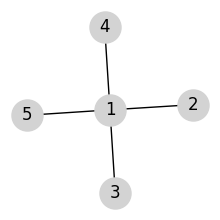

In [12]:
plt.figure(figsize=(2,2))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color="lightgray", node_size=500, with_labels=True)

In [13]:
G_si = SearchInformation(G)

In [14]:
G_average_S = G_si.get_average_search_information()
G_average_S

1.33437600046154

Run it for all the 3 networks

In [15]:
GBA_si = SearchInformation(GBA)
GER_si = SearchInformation(GER)
GWS_si = SearchInformation(GWS)

In [16]:
GBA_average_S = GBA_si.get_average_search_information()
GER_average_S = GER_si.get_average_search_information()
GWS_average_S = GWS_si.get_average_search_information()

In [17]:
GBA_average_S

11.954044181978803

In [18]:
GER_average_S

13.05781982349485

In [19]:
GWS_average_S

15.970138361117076

**Comparing the results:**

The bigger the **Average Search Information** the bigger the information needed to navegate in the network. It's worth mentioning that this measure grows in log2, so a small change means a lot.


**Barabasi Albert**

In this case, **Barabasi Albert** has the smaller **Seach Information**. This makes sense if you consider that this network contains **HUBS**, that is, nodes with many connections, which in this case can be interpreted as **important avenues** that have intersections with several streets, which facilitates navigation through the graph.

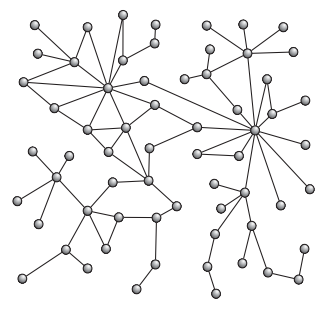

Source: Characterization of complex networks: A survey of measurements

**Erdős–Rényi**

The second smallest is the **Erdős–Rényi** network, which due to its random nature, it makes sense that the topology neither hinders nor facilitates navigation between nodes, resulting in a **Search Information** greater than that of barabasi albert, and smaller than that of small world

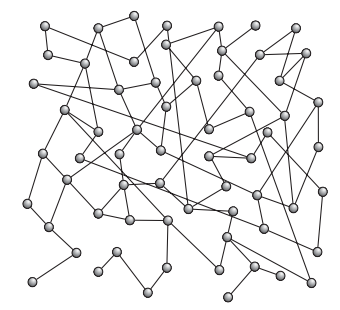

Source: Characterization of complex networks: A survey of measurements

**Watts and Strogatz**

The one with the biggest **Search Information** is **Watts and Strogatz**. It makes sense that its **Search Information** is bigger than the previously mentioned ones, because we use **p = 0.05**, and for p close to 0 the network is regular, with many triangles and large distances. Which in this case can be interpreted as neighborhoods that are very connected to each other, and there is a certain difficulty in leaving this neighborhood to reach another.

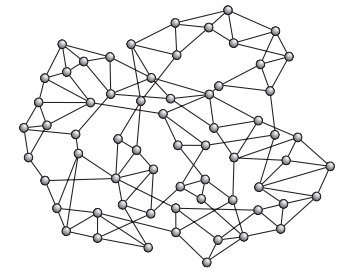

Source: [Characterization of complex networks: A survey of measurements](https://arxiv.org/abs/cond-mat/0505185)

**Small World** with **p = 0.95** to verify it´s search information:

In [20]:
GWS_p95 = nx.watts_strogatz_graph(N, k, 0.95, seed=None)

In [21]:
#get the biggest component to avoid infinity distances
GWS_p95 = get_biggest_component(GWS_p95)
GWS_p95 = nx.convert_node_labels_to_integers(GWS_p95)
len(GWS_p95)

5

In [22]:
GWS_p95_si = SearchInformation(GWS_p95)
GWS_p95_si.get_probability_shortest_path_matrix()

array([[1.        , 0.08333333, 0.08333333, 0.08333333, 0.08333333],
       [0.08333333, 1.        , 0.08333333, 0.08333333, 0.08333333],
       [0.08333333, 0.08333333, 1.        , 0.08333333, 0.08333333],
       [0.08333333, 0.08333333, 0.08333333, 1.        , 0.08333333],
       [0.08333333, 0.08333333, 0.08333333, 0.08333333, 1.        ]])

In [23]:
GWS_p95_prob_shortest_path = GWS_p95_si.get_average_search_information()
GWS_p95_prob_shortest_path

2.8679700005769244

We can see that **Search information** has **decreased** considerably, which makes sense since for p ~ 1, it becomes a random network, with small
distances and few triangles.

# Real Cities Analysis

Of course, after implementing the measure, we want to test it on a Real City Network. With this purpose we can use the library OSMNX, which provides graphs of maps from Open Street Maps

In [24]:
place = 'Cidade Jardim, São Carlos, São Paulo, Brazil'
G = (ox.graph_from_place(place))
G = ox.get_undirected(ox.projection.project_graph(G))

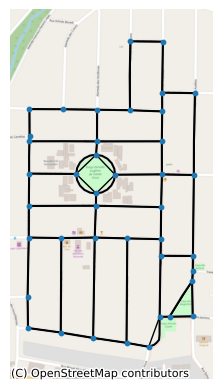

In [25]:
nodes, streets  = ox.graph_to_gdfs(G)
ax = streets.plot(color="k")

nx.draw(
    G, {idx: [data['x'], data['y']] for idx, data in list(G.nodes(data=True))},ax=ax, node_size=10
)

cx.add_basemap(ax, crs=streets.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.axis("off")
plt.show()

Altough this graph looks very interesting, it does not have much utility. The main components of a graph are nodes and edges, which should represent important things we want to map. The corners of a city does not represent important information.

This said, we should represent the fetch graph, called **Primal Graph**, as a **Dual Graph**. The base process is kind of simple: transform nodes into edges and edges into nodes. But, we want to remap all street edges of the primal graph as a single node that represents the whole street.

The function is implemented in a different file, called `street_continuity.py()`

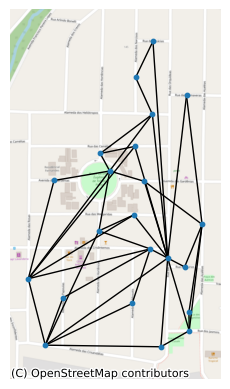

In [26]:
nG = StreetContinuity.get_dual_graph(G)

fig, ax = plt.subplots()

nx.draw(
    nG, {idx: [data['x'], data['y']] for idx, data in list(nG.nodes(data=True))},ax=ax, node_size=10
)
cx.add_basemap(ax, crs=G.graph['crs'], source=cx.providers.OpenStreetMap.Mapnik)
ax.axis("off")

plt.show()

There is one more problem to use this measure: it takes excessive computational power. To deal with this, let's see what Random Graphs best mimic Real Graphs

In [54]:
places = [
#     ['Campo Limpo, São Paulo, Brazil'],
    ['Grajaú, São Paulo, Brazil'],
    ['Capão Redondo, São Paulo, Brazil'],
    ['República, São Paulo, Brazil'],
    ['Jardim Ângela, São Paulo, Brazil'],
    ['Centro, São Paulo, Brazil'],
    ['Moema, São Paulo, Brazil'],
    ['Higienópolis, São Paulo, Brazil'],
    ['Itaim Bibi, São Paulo, Brazil'],
]


graph_list = []
avg_list = []
stats = {}
for place in places:
    G = ox.graph_from_place(place, network_type='drive', which_result=1)
    G = ox.get_undirected(ox.projection.project_graph(G))
    dual_graph = StreetContinuity.get_dual_graph(G)
    graph_list.append((place, dual_graph))

In [56]:
from graph_compare import GraphCompare

In [57]:
for place, graph in graph_list:
    graph_compare = GraphCompare(nG, f"-{place[0]}", "cidade")
    graph_compare.make_pca()
#     graph_compare.plot_pca()
#     graph_compare.pca_file()
    graph_compare.make_knn()

Graph -Grajaú, São Paulo, Brazil is similar to e. Barabasi-Albert (KNN = 3)
Graph -Capão Redondo, São Paulo, Brazil is similar to e. Barabasi-Albert (KNN = 3)
Graph -República, São Paulo, Brazil is similar to e. Barabasi-Albert (KNN = 3)
Graph -Jardim Ângela, São Paulo, Brazil is similar to e. Barabasi-Albert (KNN = 3)
Graph -Centro, São Paulo, Brazil is similar to a. Erdos-Renyi (KNN = 3)
Graph -Moema, São Paulo, Brazil is similar to e. Barabasi-Albert (KNN = 3)
Graph -Higienópolis, São Paulo, Brazil is similar to e. Barabasi-Albert (KNN = 3)
Graph -Itaim Bibi, São Paulo, Brazil is similar to e. Barabasi-Albert (KNN = 3)


Here, we can see that Barabasi Albert model has the best approach to represent a city dual graph

Let's visualize one real graph

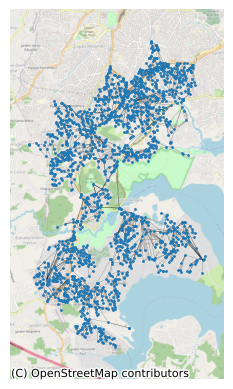

In [58]:
_, graph_to_draw = graph_list[3]

fig, ax = plt.subplots()

nx.draw(
    graph_to_draw, 
    {idx: [data['x'], data['y']] for idx, data in list(graph_to_draw.nodes(data=True))},
    ax=ax, node_size=1, width=0.1
)
cx.add_basemap(ax, crs=G.graph['crs'], source=cx.providers.OpenStreetMap.Mapnik)
ax.axis("off")

plt.show()

In [91]:
from graph_compare import create_df, Graph

list_si = []

ba_graph_list = []
for i in range(50):
    ba = nx.barabasi_albert_graph(200, 2)
    ba_graph_list.append(Graph(ba, "BA Graph"))
    si = SearchInformation(ba)
    avg = si.get_average_search_information()
    list_si.append(avg)
    
df = create_df(ba_graph_list)   
df['_search_info'] = list_si
df['_g']

print(df)

df.drop

df = (df-df.min())/(df.max()-df.min())

name         _density _spl_mean   _c_mean  _c_stdev _dg_mean _dg_stdev  \
BA Graph-0   0.019899  3.297588  0.097661  0.265748     3.96   4.52224   
BA Graph-1   0.019899  3.411156  0.069139  0.223146     3.96  3.765541   
BA Graph-2   0.019899  3.284472    0.0588  0.187208     3.96  4.567572   
BA Graph-3   0.019899  3.295779  0.092508  0.265477     3.96  4.391449   
BA Graph-4   0.019899  3.360603  0.109483  0.283789     3.96  4.194804   
BA Graph-5   0.019899  3.357186  0.077461  0.216775     3.96  4.288397   
BA Graph-6   0.019899  3.514573  0.035386  0.135867     3.96  3.505688   
BA Graph-7   0.019899  3.355528  0.092705  0.244852     3.96  4.367353   
BA Graph-8   0.019899  3.216131  0.087306  0.251222     3.96  4.981211   
BA Graph-9   0.019899  3.434724  0.070261  0.218189     3.96  3.806685   
BA Graph-10  0.019899  3.399598   0.07957   0.23461     3.96   4.16716   
BA Graph-11  0.019899  3.380603  0.073913  0.225373     3.96  3.988476   
BA Graph-12  0.019899  3.350151  0.035

ZeroDivisionError: float division by zero

In [ ]:
corr_df = df.corr()

In [ ]:
si_corr = corr_df['_search_info']
si_corr